# <h1><center> Homework 2 Assignment </center></h1>
### <h2><center> Computer Music Representations and Models Course </center></h2>
#### <h3><center> Acoustics Engineering @ Politecnico di Milano </center></h3>


In [25]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
import csv

##### Question 1
<!-->in this element is loaded the main answer to the first question<!-->
Implementation of _template based chord recognition function_. Given an audio file, and some control parameters as the input of the function, it will extrapolate the chord sequence based on the audio feature extrapolation 

In [4]:
def stft_basic(x, w, H=8):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Args:
        x: Signal to be transformed
        w: Window function
        H: Hopsize

    Returns:
        X: The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int)
    X = np.zeros((N, M + 1), dtype='complex')
    for m in range(M + 1):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win
    K = (N + 1) // 2
    X = X[:K, :]
    return X

In [5]:
#creation of the main chord templates for the recognition algorithm 
template_cmaj = np.array([[1,0,0,0,1,0,0,1,0,0,0,0]]).T
template_cmin = np.array([[1,0,0,1,0,0,0,1,0,0,0,0]]).T

In [6]:
#function that generates a template matrix shifting chords pattern (e.g. C_maj, C_min...) in all 12 keys. 
# the function expects a matrix of dimensions (12,n) containing n possibile patterns  
def generate_template_matrix(templates):
    template_matrix = np.zeros((12,12 * templates.shape[1]))
    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates,shift, axis = 0)
    return template_matrix

([<matplotlib.axis.XTick at 0x20a7e06afa0>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C#'),
  Text(2, 0, 'D'),
  Text(3, 0, 'D#'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F'),
  Text(6, 0, 'F#'),
  Text(7, 0, 'G'),
  Text(8, 0, 'G#'),
  Text(9, 0, 'A'),
  Text(10, 0, 'A#'),
  Text(11, 0, 'B'),
  Text(12, 0, 'C_m'),
  Text(13, 0, 'C#_m'),
  Text(14, 0, 'D_m'),
  Text(15, 0, 'D#_m'),
  Text(16, 0, 'E_m'),
  Text(17, 0, 'F_m'),
  Text(18, 0, 'F#_m'),
  Text(19, 0, 'G_m'),
  Text(20, 0, 'G#_m'),
  Text(21, 0, 'A_m'),
  Text(22, 0, 'A#_m'),
  Text(23, 0, 'B_m')])

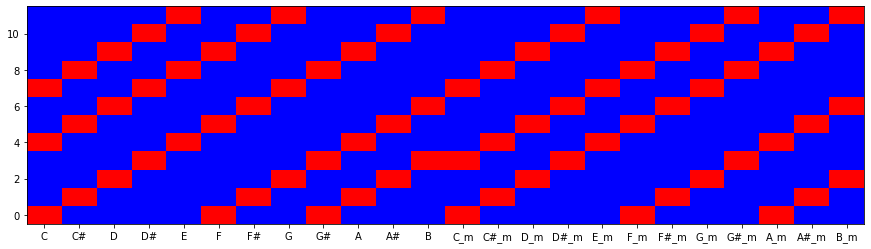

In [7]:
templates = generate_template_matrix(np.concatenate((template_cmaj,template_cmin), axis = 1))

plt.figure(figsize=(15,4))
plt.imshow(templates, origin="lower", aspect = "auto", cmap = "bwr")

chroma_labels = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
chroma_labels_maj = chroma_labels
chroma_labels_min = [s+'_m' for s in chroma_labels]
chroma_labels = np.concatenate((chroma_labels_maj, chroma_labels_min), axis = 0)
plt.xticks(np.arange(24), chroma_labels)

In [8]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Args:
        X: Feature sequence
        norm: The norm to be applied. '1', '2', 'max'
        threshold: An+ threshold below which the vector `v` used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm

    Returns:
        X_norm: Normalized feature sequence
    """
    
    K, N = X.shape
    X_norm = np.zeros((K,N))
    #print("this is K")
    #print(K)
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.sum(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
                
    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in np.arange(N):
            p = np.sqrt(np.sum(X[:,n]**2))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v   
    
    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.max(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
    #print("this is v")
    #print(v)
    return X_norm

In [9]:
from scipy import signal

def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
    """
    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
        
    Hint: use numpy expand dims to obtain a window of dimension (1, L)
    """
    
    filter_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth =  signal.convolve(X, filter_kernel, mode='same') / filt_len 
    
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    
    return X_smooth, Fs_feature

In [42]:
def analysis_template_match(chromagram, templates, Fs = 22050, norm_chromagram = '2', norm_output ='2', 
                            smoothing_window_length = None, smoothing_down_sampling = None):
    chromagram_normalized = normalize_feature_sequence(chromagram, norm_chromagram)
    
    if smoothing_down_sampling and smoothing_window_length:
        chromagram_normalized, Fs_feature = smooth_downsample_feature_sequence(chromagram_normalized, Fs,
                                                                           down_sampling=smoothing_down_sampling,
                                                                          filt_len=smoothing_window_length)
    else:
        Fs_feature = Fs
    template_normalized = normalize_feature_sequence(templates,    
                                                     norm = norm_chromagram)
    
    chord_similarity = np.matmul(template_normalized.T, chromagram_normalized)
    
    if norm_output:
        chord_similarity = normalize_feature_sequence(chord_similarity, norm=norm_output)
        
    chord_max_labels = (chord_similarity == chord_similarity.max(axis = 0)).astype(int) #boolean matrix
    
    
    return chord_similarity, chord_max_labels, Fs_feature


In [44]:
fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
Fs = 22050
x,Fs = librosa.load(fn_wav, sr=Fs)


N = 4096
H = 2048
X = librosa.stft(x, n_fft = N, hop_length = H, pad_mode = 'constant', center = True)
X = np.abs(X)**2

C = librosa.feature.chroma_stft(S=X, sr = Fs, tuning = 0, hop_length = H, n_fft = N)

chord_sim, chord_max,Fs_feature = analysis_template_match(C, templates, 
                                               smoothing_window_length=7, 
                                               smoothing_down_sampling=7,
                                               norm_chromagram = '2', 
                                               norm_output = 'max')

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


([<matplotlib.axis.YTick at 0x20a00731970>,
 [Text(0, 0, 'C'),
  Text(0, 1, 'C#'),
  Text(0, 2, 'D'),
  Text(0, 3, 'D#'),
  Text(0, 4, 'E'),
  Text(0, 5, 'F'),
  Text(0, 6, 'F#'),
  Text(0, 7, 'G'),
  Text(0, 8, 'G#'),
  Text(0, 9, 'A'),
  Text(0, 10, 'A#'),
  Text(0, 11, 'B'),
  Text(0, 12, 'C_m'),
  Text(0, 13, 'C#_m'),
  Text(0, 14, 'D_m'),
  Text(0, 15, 'D#_m'),
  Text(0, 16, 'E_m'),
  Text(0, 17, 'F_m'),
  Text(0, 18, 'F#_m'),
  Text(0, 19, 'G_m'),
  Text(0, 20, 'G#_m'),
  Text(0, 21, 'A_m'),
  Text(0, 22, 'A#_m'),
  Text(0, 23, 'B_m')])

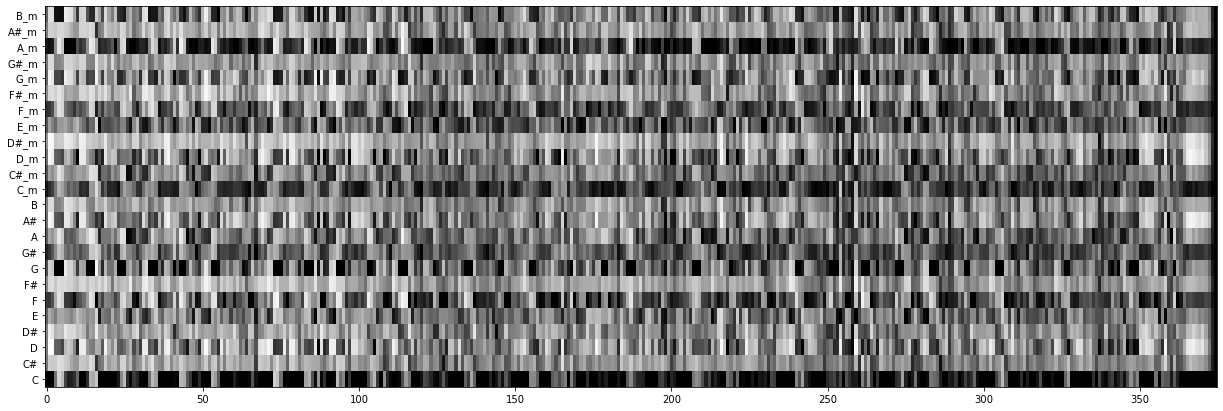

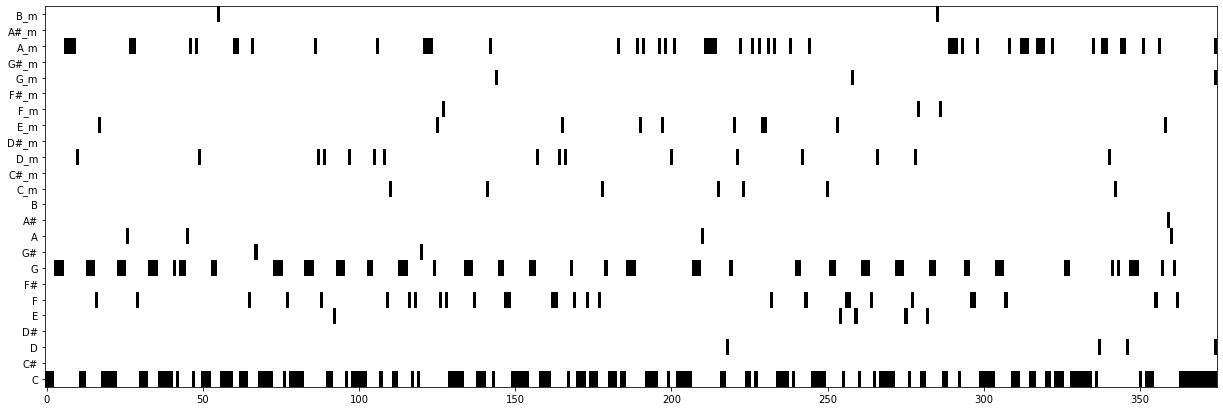

In [45]:
#print(chord_sim)
print(chord_max)
fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_sim, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)
fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_max, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)


In [68]:
def chordList(filePath,Fs = 22050,N = 4096,H = 2048,smoothing_window_length=None, smoothing_down_sampling=None):
    
    x,Fs = librosa.load(filePath, sr=Fs)
    X = librosa.stft(x, n_fft = N, hop_length = H, pad_mode = 'constant', center = True)
    X = np.abs(X)**2
    C = librosa.feature.chroma_stft(S=X, sr = Fs, tuning = 0, hop_length = H, n_fft = N)
    chord_sim, chord_max, Fs_feature = analysis_template_match(C, templates, 
                                               smoothing_window_length=smoothing_window_length, 
                                               smoothing_down_sampling=smoothing_down_sampling,
                                               norm_chromagram = '2', 
                                               norm_output = 'max')
    K, N = chord_max.shape
    print(K)
    chordList = []
    for i in np.arange(N):
        pos = chord_max[:,i]
        #print(pos)
        maxPos = np.where(pos != 0)
        print(maxPos[0])
        if maxPos[0].size == 1:
            #print(len(maxPos))
            chordList.append(chroma_labels[maxPos[0].item(0)])
            #print(chordList)
        else:
            #print("stupido")
            #print(len(maxPos))
            chordList.append("random")
    
    return chordList, Fs_feature

In [72]:
fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav',)

chordListValue, Fs_featureVal = chordList(fn_wav,smoothing_window_length=7, smoothing_down_sampling=7)

24
[0]
[0]
[0]
[7]
[7]
[7]
[21]
[21]
[21]
[21]
[14]
[0]
[0]
[7]
[7]
[7]
[5]
[16]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[7]
[9]
[21]
[21]
[5]
[0]
[0]
[0]
[7]
[7]
[7]
[0]
[0]
[0]
[0]
[0]
[7]
[0]
[7]
[7]
[9]
[21]
[0]
[21]
[14]
[0]
[0]
[0]
[7]
[7]
[23]
[0]
[0]
[0]
[0]
[21]
[21]
[0]
[0]
[0]
[5]
[21]
[8]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[7]
[0]
[5]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[7]
[21]
[14]
[5]
[14]
[0]
[0]
[4]
[7]
[7]
[7]
[0]
[14]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[14]
[21]
[0]
[14]
[5]
[12]
[0]
[0]
[7]
[7]
[7]
[5]
[0]
[5]
[0]
[8]
[21]
[21]
[21]
[7]
[16]
[5]
[17]
[5]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[7]
[5]
[0]
[0]
[0]
[12]
[21]
[0]
[19]
[7]
[7]
[5]
[5]
[0]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[14]
[0]
[0]
[0]
[0]
[5]
[5]
[14]
[16]
[14]
[0]
[7]
[5]
[0]
[0]
[0]
[5]
[0]
[0]
[0]
[5]
[12]
[7]
[0]
[0]
[0]
[21]
[0]
[0]
[7]
[7]
[7]
[21]
[16]
[21]
[0]
[0]
[0]
[0]
[21]
[16]
[21]
[0]
[14]
[21]
[0]
[0]
[0]
[0]
[0]
[7]
[7]
[7]
[9]
[21]
[21]
[21]
[21]
[12]
[0]
[0]
[2]
[7]
[16]
[14]
[21]
[12]
[0]
[0]
[21]
[0]
[21]
[16]
[16]
[21]
[5]
[21]
[

#### Question 2

In [73]:
def loadCSV(csvFileName,Fs_value):
    
    with open(csvFileName, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        toRet = []
        timeAccumulator = 0
        for row in reader:
            while timeAccumulator <= float(row['End']):
                toRet.append(row['Label'])
                timeAccumulator += 1/Fs_value
                # print(timeAccumulator)
        return toRet
                
        

In [74]:
print(Fs_feature)
loadCSV("./data/csv/Beatles_LetItBe.csv",Fs_feature)

3150.0


['C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C'